In [92]:
import operator
from typing import Dict, List

import pandas as pd
import yfinance as yf
from tools import roc, sma

In [93]:
INIT_DEPOT = 10_000
START_DATE = "2021-01-01"

In [94]:
def ndx100_list():
    table = pd.read_html("https://en.wikipedia.org/wiki/Nasdaq-100#Components")[4]
    return list(table.Ticker)

In [95]:
def stock_score(data: pd.DataFrame) -> pd.Series:
    return roc(data.Close, 100)

In [96]:
def resample_index_to_month(df: pd.DataFrame) -> pd.DataFrame:
    df["Date"] = df.index
    df["month"] = df["Date"].dt.strftime("%y-%m")

    df = df.groupby("month").agg(
        Date=("Date", "last"),
        Close=("Close", "last"),
        above_sma=("above_sma", "last"),
    )
    return df.reset_index().set_index("Date").sort_index()

In [97]:
def resample_stocks_to_month(df: pd.DataFrame) -> pd.DataFrame:
    df["Date"] = df.index
    df["month"] = df["Date"].dt.strftime("%y-%m")

    df = df.groupby("month").agg(
        Date=("Date", "last"),
        Open=("Open", "first"),
        Close=("Close", "last"),
        score=("score", "last"),
    )
    return df.reset_index().set_index("Date").sort_index()

In [98]:
def get_stocks(symbols: List[str]) -> Dict[str, pd.DataFrame]:
    """_summary_

    Args:
        symbols (List[str]): _description_

    Returns:
        Dict[str, pd.DataFrame]: _description_
    """

    dfs = {}
    stock_data = yf.download(
        symbols,
        rounding=2,
        progress=False,
        group_by="ticker",
    )

    # perform some pre preparation
    for symbol in stock_data.columns.get_level_values(0).unique():
        # drop unclear items
        df = stock_data[symbol]
        df = df[~(df.High == df.Low)]
        df = df.dropna()
        df.index = pd.to_datetime(df.index)

        dfs[symbol.lower()] = df

    return dfs

In [99]:
sp_500 = yf.download("^GSPC")
ndx_100 = yf.download("^NDX")

sp_500 = sp_500[START_DATE:]
ndx_100 = ndx_100[START_DATE:]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [100]:
sp_500["above_sma"] = sp_500.Close > sma(sp_500.Close, 275)

In [101]:
sp_500 = resample_index_to_month(sp_500)

In [102]:
stocks = get_stocks(ndx100_list())

In [103]:
tracker = sp_500[["above_sma", "month"]]

for symbol, df in stocks.items():
    df["score"] = stock_score(df)
    df = resample_stocks_to_month(df)
    df[symbol] = df["score"]

    # Add score to tracker
    tracker = pd.merge(
        tracker, df[[symbol]], left_index=True, right_index=True, how="left"
    )
    tracker["next"] = tracker.month

In [109]:
start_depot = INIT_DEPOT
depot_development = []
MAX_STOCKS = 10
transactions = []

for index, row in tracker[tracker.above_sma == 1].iterrows():
    active_period = row["next"]
    current_symbols = dict(row)
    current_symbols.pop("above_sma")
    current_symbols.pop("next")
    current_symbols.pop("month")

    montly_basket = {}
    symbols = []
    monthly_investment = 0

    transactions.append(
        {"month": active_period, "symbol": "CASH", "qty": 1, "price": start_depot}
    )

    # current month symbols
    active_symbols = list(
        set(tracker.columns).intersection([x.lower() for x in ndx100_list()])
    )

    current_symbols = {k: v for (k, v) in current_symbols.items() if v > 0}

    # Sort the symbols by their score
    top_stocks = sorted(current_symbols.items(), key=operator.itemgetter(1))

    for symbol in [ticker for (ticker, _) in top_stocks[-MAX_STOCKS:]]:
        df = stocks[symbol]

        buy_price = df[df.month == active_period].Open.values[0]
        sell_price = df[df.month == active_period].Close.values[-1]

        qty = (start_depot / MAX_STOCKS) // buy_price
        monthly_investment += qty * -buy_price
        monthly_investment += qty * sell_price

        transactions.append(
            {
                "month": active_period,
                "symbol": symbol,
                "qty": (start_depot / MAX_STOCKS) // buy_price,
                "price": -buy_price,
            }
        )
        transactions.append(
            {
                "month": active_period,
                "symbol": symbol,
                "qty": (start_depot / MAX_STOCKS) // buy_price,
                "price": sell_price,
            }
        )
        symbols.append(symbol)

    start_depot = round(start_depot + monthly_investment, 2)
    depot_development.append({"month": active_period, "Total_mix": start_depot})

    # print(symbols)

In [111]:
transactions = pd.DataFrame(transactions)
transactions["sum"] = transactions.qty * transactions.price
transactions.groupby("month").agg(
    sum=("sum", "sum"),
)

,month,symbol,qty,price,sum
0,22-02,CASH,1.0,10000.00,10000.00
1,22-02,avgo,1.0,-585.87,-585.87
2,22-02,avgo,1.0,587.44,587.44
3,22-02,exc,24.0,-41.13,-987.12
4,22-02,exc,24.0,42.56,1021.44
...,...,...,...,...,...
331,24-04,meta,6.0,481.07,2886.42
332,24-04,ceg,17.0,-186.03,-3162.51
333,24-04,ceg,17.0,180.90,3075.30
334,24-04,nvda,3.0,-902.99,-2708.97


In [106]:
depot_development = pd.DataFrame(depot_development)
depot_development = pd.merge(
    sp_500[["month"]].copy().reset_index(), depot_development, on="month", how="left"
).set_index("Date")

depot_development.loc[depot_development.iloc[0].name, "Total_mix"] = INIT_DEPOT
depot_development["Total_mix"] = depot_development["Total_mix"].ffill()

In [107]:
sp_500["Cum Return"] = sp_500["Close"] / sp_500.iloc[0].Close
sp_500["Cum Return %"] = (sp_500["Cum Return"] - 1) * 100
sp_500["Total"] = (sp_500["Cum Return"] * INIT_DEPOT).round()

ndx_100["Cum Return"] = ndx_100["Close"] / ndx_100.iloc[0].Close
ndx_100["Cum Return %"] = (ndx_100["Cum Return"] - 1) * 100
ndx_100["Total"] = (ndx_100["Cum Return"] * INIT_DEPOT).round()

<Axes: title={'center': 'Portfolio'}, xlabel='Date'>

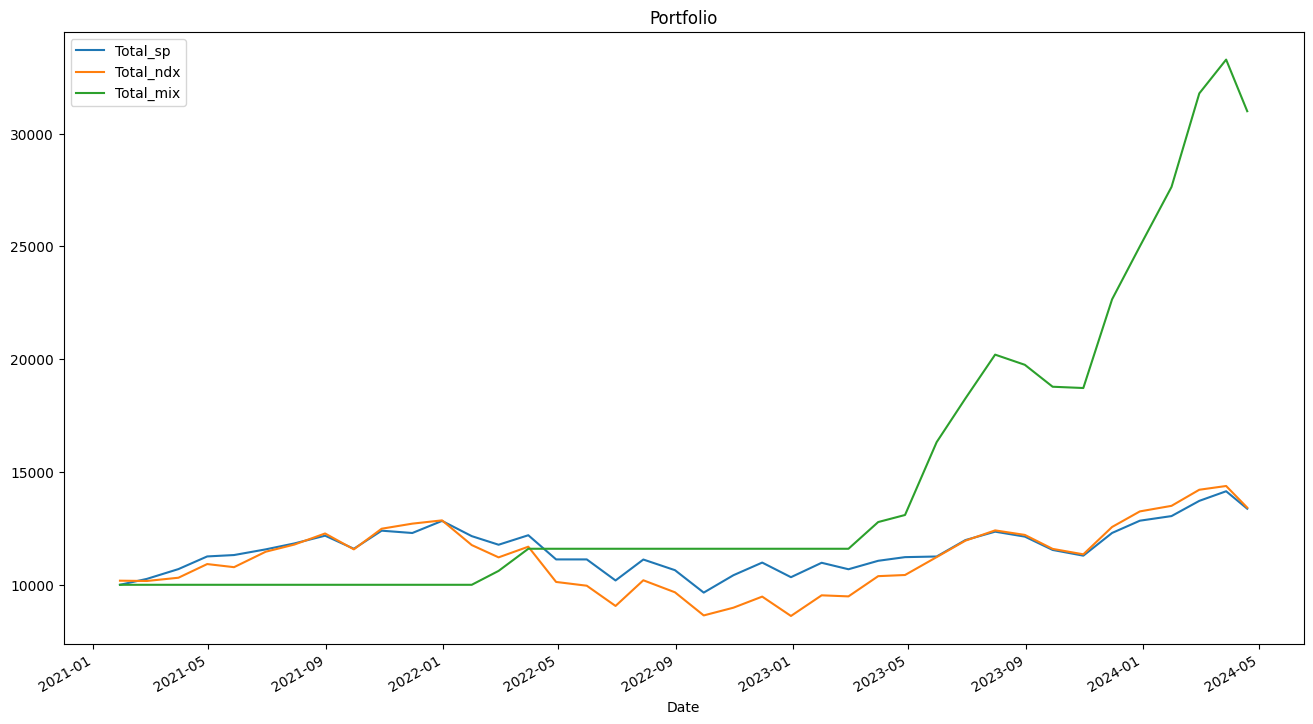

In [108]:
portfolio = pd.merge(
    sp_500[["Total", "month"]],
    ndx_100[["Total"]],
    left_index=True,
    right_index=True,
    suffixes=("_sp", "_ndx"),
)

portfolio = pd.merge(
    portfolio,
    depot_development["Total_mix"],
    left_index=True,
    right_index=True,
)

portfolio.plot(title="Portfolio", figsize=(16, 9))